В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
#Copy of NeuralNet for 1 hidden layer
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,
                 hidden_layer_sizes =(4,4),not_improve_iters =500,tol =1e-5):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes =hidden_layer_sizes;
        self.layers_count =len(hidden_layer_sizes);
        self.not_improve_iters =not_improve_iters;
        self.tol =tol;
        self.hidden_layers_count=len(hidden_layer_sizes);
        self.hidden_layer_sizes =hidden_layer_sizes;
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0 # у вихідному шарі лише 1 нейрон
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[];
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if i%self.not_improve_iters ==0:
                improve_costs.append(cost);
                imp_len =len(improve_costs);
                if imp_len >2:
                    if abs(improve_costs[imp_len-1] - improve_costs[imp_len-2]) < self.tol:
                        return;
            
            
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


In [5]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,
                 hidden_layer_sizes =(5,10),not_improve_iters =500,tol =1e-10):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
        self.hidden_layer_sizes =hidden_layer_sizes;
        self.layers_count =len(hidden_layer_sizes);
        
        self.not_improve_iters =not_improve_iters;
        self.tol =tol;
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_arr):
        layers =len(n_arr);
        W_arr =[];
        b_arr =[];
        #Init first layer
        W_first = np.random.randn(n_arr[0], n_x) * 0.01;
        b_first = np.zeros((n_arr[0], 1));
        W_arr.append(W_first);
        b_arr.append(b_first);
        
        # Перебрати всі слої окрім першого та останнього
        ##???
        for n_l in range(1,layers):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        #Init last layer
        W_last =np.random.randn(1, n_arr[layers-1]) * 0.01
        b_last = 0;# The last layer has only one neuron
        
        W_arr.append(W_last);
        b_arr.append(b_last);
        
        print("Init parameters.")
        print("W coefs len: ",len(W_arr)," b coefs len: ",len(b_arr));
        
        for w_debug in W_arr:
            print("W shape: ",w_debug.shape);
        
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    def __forward_propagation(self, X):
        
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]
        
        W_first = W_arr[0];
        b_first = b_arr[0];
        
        W_last =W_arr[len(W_arr)-1];
        b_last =b_arr[len(b_arr)-1];
        
        Z_arr =[];
        A_arr =[];
        
        Z_first =np.dot(W_first,X)+b_first;
        A_first = self.__sigmoid(Z_first);
        
        
        Z_arr.append(Z_first);
        A_arr.append(A_first);
        
        layers = self.layers_count;
        for l in range(1,layers+1):#range(1,layers) -> range(1,layers+1)
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);

        cache =(W_arr,b_arr,Z_arr,A_arr);
        ##debug
#         print("__forward_propagation:")
#         print("W_arr shapes:")
#         for w_debug in W_arr:
#             print("W shape: ",w_debug.shape);
        
#         print("Z_arr shapes:")
#         for z_debug in Z_arr:
#             print("Z shape: ",z_debug.shape);
            
            
#         print("A_arr shapes:")
#         for a_debug in Z_arr:
#             print("A shape: ",a_debug.shape);
        
        return A_arr[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        #(W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        (W_arr,b_arr,Z_arr,A_arr) = cache
        
        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];
        
        dZ_last = A_arr[-1] -Y;# Get last A
        dW_last = 1. / m * np.dot(dZ_last, A_arr[-2].T);
        db_last =1. / m * np.sum(dZ_last, axis = 1, keepdims = True);
        dA_last =np.dot(W_arr[-1].T,dZ_last);
        
        dZ_arr.insert(0,dZ_last); # insert value at front
        dW_arr.insert(0,dW_last);
        db_arr.insert(0,db_last);
        dA_arr.insert(0,dA_last);
        
        # inverse iter till the first element(not inc.)
#         print("Debug place")
#         print("m = ",m)
#         print("n = ",n)
        for l_inv in range(len(W_arr)-2,0,-1):
#             print("-----------------")
#             print("W shape: ",W_arr[l_inv].shape)
#             print("W.T shape: ",W_arr[l_inv].T.shape);
#             print("dZ shape: ",dZ_arr[0].shape);
            
            #dA_temp =np.dot(W_arr[l_inv].T,dZ_arr[0]);
            
            #print("dA_temp shape: ",dA_temp.shape);
            
            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv])); #A_arr[l_inv] ->A_arr[l_inv-1]
            
#             print("dZ_temp shape: ",dZ_temp.shape);
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);#A_arr[l_inv] ->A_arr[l_inv-1]
            
#             print("dW_temp shape: ",dW_temp.shape);
            
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            
#             print("db_temp shape: ",db_temp.shape);
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        
        
        #dA_first=np.dot(W_arr[0].T, dZ_arr[0]);#W_arr[1].T ->W_arr[0].T
        dA_first =dA_arr[0];
        dZ_first = np.multiply(dA_first, np.multiply(A_arr[0], 1 - A_arr[0]));
        dW_first = 1. / m * np.dot(dZ_first, X.T)
        db_first =1. / m * np.sum(dZ_first, axis = 1, keepdims = True)
        
        dZ_arr.insert(0,dZ_first); # insert value at front
        dW_arr.insert(0,dW_first);
        #dA_arr.insert(0,dA_first);
        db_arr.insert(0,db_first);
        
        #dZ2 = A2 - Y
        #dW2 = 1. / m * np.dot(dZ2, A1.T)
        #db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        #dA1 = np.dot(W2.T, dZ2)
        #dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        #dW1 = 1. / m * np.dot(dZ1, X.T)
        #db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        #grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
    
    def __update_parameters(self, grads):
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];
        
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];
        
        W_new_arr =W_arr.copy();
        b_new_arr = b_arr.copy();
        for l in range(0,len(W_arr)):
            W_new_arr[l]-=self.learning_rate * dW_arr[l];
            b_new_arr[l]-=self.learning_rate * db_arr[l];
        
        self.parameters["W_arr"] = W_new_arr;
        self.parameters["b_arr"] = b_new_arr;
        
        
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[];
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            
            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if i%self.not_improve_iters ==0:
                improve_costs.append(cost);
                imp_len =len(improve_costs);
                if imp_len >2:
                    if abs(improve_costs[imp_len-1] - improve_costs[imp_len-2]) < self.tol:
                        return;
            
            
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [6]:
# data_columns = ["exam1", "exam2"]
# target_column = "submitted"
# df = pd.read_csv("sats.csv")
# X, Y = df[data_columns].values, df[target_column]
# print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [7]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


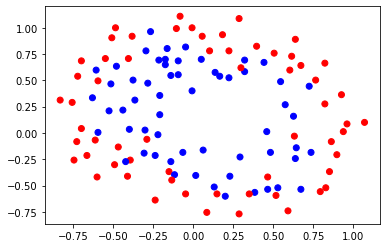

In [8]:
plot_data(X, Y)

In [9]:
cls = NeuralNet(normalize = True, learning_rate = 0.01, num_iter = 10001,hidden_layer_sizes = (2,),not_improve_iters=10000,tol=1e-8)

Init parameters.
W coefs len:  2  b coefs len:  2
W shape:  (2, 2)
W shape:  (1, 2)
0-th iteration: 0.6931280740607985
1000-th iteration: 0.6930027114913162
2000-th iteration: 0.6930010365431156
3000-th iteration: 0.6929991353314141
4000-th iteration: 0.6929967337196383
5000-th iteration: 0.6929935672054238
6000-th iteration: 0.6929892849480946
7000-th iteration: 0.6929834120138585
8000-th iteration: 0.6929752998412512
9000-th iteration: 0.6929640618706978
10000-th iteration: 0.6929484921450575


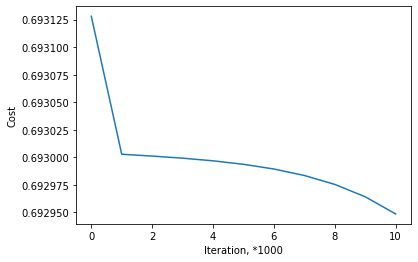

In [10]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [11]:
print(cls.parameters)

{'W_arr': [array([[0.0562424 , 0.00430544],
       [0.00550772, 0.00488977]]), array([[-0.05285654, -0.00373664]])], 'b_arr': [array([[-2.42170433e-04],
       [ 1.05986077e-05]]), array([[-0.00704974]])]}


In [12]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.49089205, 0.50910795],
       [0.49093797, 0.50906203],
       [0.49177665, 0.50822335],
       [0.49124036, 0.50875964],
       [0.49155389, 0.50844611],
       [0.49144153, 0.50855847],
       [0.49173544, 0.50826456],
       [0.49064316, 0.50935684],
       [0.49073609, 0.50926391],
       [0.49144531, 0.50855469],
       [0.49117886, 0.50882114],
       [0.49153194, 0.50846806],
       [0.4908406 , 0.5091594 ],
       [0.49112122, 0.50887878],
       [0.49133928, 0.50866072],
       [0.49080708, 0.50919292],
       [0.49167794, 0.50832206],
       [0.49074355, 0.50925645],
       [0.49122793, 0.50877207],
       [0.49104188, 0.50895812],
       [0.4912567 , 0.5087433 ],
       [0.4915196 , 0.5084804 ],
       [0.49160614, 0.50839386],
       [0.49116506, 0.50883494],
       [0.4916454 , 0.5083546 ],
       [0.4912953 , 0.5087047 ],
       [0.49168773, 0.50831227],
       [0.49145581, 0.50854419],
       [0.49113668, 0.50886332],
       [0.49106537, 0.50893463],
       [0.

In [13]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
accuracy_score(Y, Y_hat)

0.5084745762711864

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (8,), max_iter = 1000000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(8,), learning_rate_init=0.01,
              max_iter=1000000, solver='sgd')

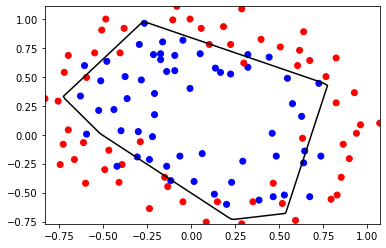

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576

In [19]:
clf.n_iter_

1843